# FinistR : bootcamp R à Roscoff

JAX is a Python library, basically a wrapper around numpy for efficient scientific programming: automatic differentiation, parallelization, JIT, etc. Many numpy functions are rewritten in a low level API called LAX. It then uses the XLA compiler to opitmization computations, see [https://jax.readthedocs.io/en/latest/notebooks/thinking_in_jax.html#numpy-lax-xla-jax-api-layering](https://jax.readthedocs.io/en/latest/notebooks/thinking_in_jax.html#numpy-lax-xla-jax-api-layering) 

## JIT with JAX

A practical definition of JIT compilation can be found in [JAX documentation](https://jax.readthedocs.io/en/latest/index.html):

_When we jit-compile a function, we usually want to compile a version of the function that works for many different argument values, so that we can cache and reuse the compiled code. That way we don’t have to re-compile on each function evaluation._

_For example, if we evaluate an `@jit` function on the array `jnp.array([1., 2., 3.], jnp.float32)`, we might want to compile code that we can reuse to evaluate the function on `jnp.array([4., 5., 6.], jnp.float32)` to save on compile time._

_By default JAX executes operations one at a time, in sequence. Using a just-in-time (JIT) compilation decorator, sequences of operations can be optimized together and run at once._

**In this tutorial we explore JAX JIT compilation on the same algorithm of the PLN model** as coded in [https://stateofther.github.io/finistR2023/torch_Python-PLN.html](https://stateofther.github.io/finistR2023/torch_Python-PLN.html).

This tutorial is to be compared with [JIT compilation in pytorch](https://stateofther.github.io/finistR2023/jit-example-pln.html)

First, we make the necessary imports

In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '' # uncomment to force CPU

In [2]:
import numpy as np
import math
import pyPLNmodels
import numpy as np
import matplotlib.pyplot as plt
from pyPLNmodels.models import PlnPCAcollection, Pln
from pyPLNmodels.oaks import load_oaks

In [3]:
import jax
import jax.numpy as jnp
import optax
jax.config.update("jax_enable_x64", False)
print(jax.devices())
myfloat = np.float32

[gpu(id=0)]


In [4]:
oaks = load_oaks()
Y = np.asarray(oaks['counts']).astype(myfloat)
Y = np.repeat(Y, 100, axis=0) # make data bigger to feel the speed up
O = np.log(oaks['offsets']).astype(myfloat)
O = np.repeat(O, 100, axis=0) # make data bigger to feel the speed up
X = np.ones([Y.shape[0],1]).astype(myfloat)

N_iter = 5000
lr = 1e-4

### JAX without JIT
This section does not use any kind of jitting. This is our baseline.

In [5]:
def _log_stirling(integer):
    integer_ = integer + (integer == 0)  # Replace 0 with 1 since 0! = 1!
    return jnp.log(jnp.sqrt(2 * jnp.pi * integer_)) + integer_ * jnp.log(integer_ / jnp.exp(1))

class PLN_no_jit:
    def __init__(self, Y, O, X): 
        self.Y = Y
        self.O = O
        self.X = X
        self.n, self.p = Y.shape
        self.d = X.shape[1]
        ## Variational parameters
        self.M = jnp.full(Y.shape, 0.0)
        self.S = jnp.full(Y.shape, 1.0)
        ## Model parameters
        self.B = jnp.zeros((self.d, self.p))
        self.Sigma = jnp.eye(self.p)
        self.Omega = jnp.eye(self.p)

    def get_Sigma(self, n, M, S) :
        return 1/n * (M.T @ M + jnp.diag(jnp.sum(S**2, axis=0)))
    
    def get_ELBO(self, optim_params):
      B, M, S = optim_params
      S2 = jnp.square(S)
      XB = self.X @ B
      A = jnp.exp(self.O + M + XB + S2/2)

      elbo = self.n/2 * jnp.log(jnp.linalg.det(self.Omega))
      elbo += jnp.sum(- A + self.Y * (self.O + M + XB) + .5 * jnp.log(S2))
      elbo -= .5 * jnp.trace(M.T @ M + jnp.diag(jnp.sum(S2, axis=0)) @ self.Omega)
      elbo += .5 * self.n * self.p  - jnp.sum(_log_stirling(self.Y))
      return -elbo

    def fit(self, N_iter, lr, tol = 1e-8) :
        ELBO = jnp.zeros(N_iter)
        optimizer = optax.adam(learning_rate=lr)#optax.chain(
            #adam(learning_rate=lr)
        #     optax.scale_by_radam(),
        #     optax.scale(-1.0),
        #     optax.clip(0.1),
        # )
        opt_state = optimizer.init((self.B, self.M, self.S))
        
        for i in range(N_iter):
            loss_value, grads = jax.value_and_grad(
                self.get_ELBO, 0
            )((self.B, self.M, self.S))
    
            updates, opt_state = optimizer.update(grads, opt_state, (self.B, self.M, self.S))
            # optim_params = optax.apply_updates((self.B, self.M, self.S), updates)
            # self.B, self.M, self.S = optim_params
    
            ## update parameters with close form
            self.Sigma = self.get_Sigma(self.n, self.M, self.S)
            self.Omega = jnp.linalg.inv(self.Sigma)
    
            objective = loss_value
            ELBO = ELBO.at[i].set(objective)
        
        return ELBO

Have a look a the way we update the ELBO vector in the previous functions. This is because JAX arrays are immutable [https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#in-place-updates](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#in-place-updates)

In [6]:
%%time
pln = PLN_no_jit(Y, O, X)

with jax.default_device(jax.devices('cpu')[0]): # as opposed to the subsequent jitted versions of the code, running this code do
    jaxELBO_no_jit = jax.block_until_ready(
        pln.fit(N_iter, lr, tol=1e-8)
    )

CPU times: user 57min 23s, sys: 1h 47min 22s, total: 2h 44min 45s
Wall time: 10min 23s


### JIT with JAX level 1: `jax.jit`

In this section, we will jit the functions used in the optimization process. Since it is not straightforward to JIT compilation class methods (see subsequent section), we will not use a class anymore. 

Thus, we first create an independant function to initialize variables.

In [7]:
def init_params(Y, O, X): 
    n, p = Y.shape
    d = X.shape[1]
    ## Variational parameters
    M = jnp.full(Y.shape, 0.0)
    S = jnp.full(Y.shape, 1.0)
    ## Model parameters
    B = jnp.zeros((d, p))
    Sigma = jnp.eye(p)
    Omega = jnp.eye(p)

    return n, p, d, M, S, B, Sigma, Omega

Let's create the jitted functions. Note that `_log_stirling` will be automatically jitted when called the jitted `get_ELBO`. The actual _Just In Time_ compilation will actually happen at the first execution of the jitted function. Note that the call `jax.jit()` is equivalent to using the decorator `@jax.jit`

In [8]:
def _log_stirling(integer):
    integer_ = integer + (integer == 0)
    return jnp.log(jnp.sqrt(2 * jnp.pi * integer_)) + integer_ * jnp.log(integer_ / jnp.exp(1))
    
def get_ELBO(optim_params, other_params): 
    B, M, S = optim_params['B'], optim_params['M'], optim_params['S']
    X, O, n, Omega, Y, p = (other_params['X'], other_params['O'], 
        other_params['n'], other_params['Omega'], other_params['Y'],
        other_params['p'])
    S2 = jnp.square(S)
    XB = X @ B
    A = jnp.exp(O + M + XB + S2/2)

    elbo = 0.
    elbo = n / 2 * jnp.log(jnp.linalg.det(Omega))
    elbo += jnp.sum(- A + Y * (O + M + XB) + .5 * jnp.log(S2))
    elbo -= .5 * jnp.trace(M.T @ M + jnp.diag(jnp.sum(S2, axis = 0)) @ Omega)
    elbo += .5 * n * p  - jnp.sum(_log_stirling(Y))
    return -elbo

jit_loss_and_grad = jax.jit(jax.value_and_grad(get_ELBO, 0)) # JIT !

def get_Sigma(n, M, S) :
    return 1/n * (M.T @ M + jnp.diag(jnp.sum(S**2, axis = 0)))

jit_getSigma = jax.jit(get_Sigma) # JIT !

jit_inv = jax.jit(jnp.linalg.inv) # JIT !

In the following, each function inside the for loop is jitted but the for loop
is not jitted itself; it is inefficient to do so in JAX mostly due to the long compilation time it would induce, see [https://jax.readthedocs.io/en/latest/faq.html#jit-decorated-function-is-very-slow-to-compile](https://jax.readthedocs.io/en/latest/faq.html#jit-decorated-function-is-very-slow-to-compile).

In [9]:
def jaxfit1(optim_params, other_params, N_iter, lr, tol = 1e-8) :
    ELBO = jnp.zeros(N_iter)
    optimizer = optax.chain(
        #adam(learning_rate=lr)
        optax.scale_by_radam(),
        optax.scale(-1.0),
        optax.clip(0.1),
    )
    opt_state = optimizer.init(optim_params)
    objective0 = jnp.inf

    update = jax.jit(optimizer.update)
    apply_updates = jax.jit(optax.apply_updates)

    for i in range(N_iter):
        loss_value, grads = jit_loss_and_grad(
            optim_params,
            other_params
        )

        updates, opt_state = update(grads, opt_state, optim_params)
        optim_params = apply_updates(optim_params, updates)

        ## update parameters with close form
        other_params['Sigma'] = jit_getSigma(other_params['n'], optim_params['M'],
        optim_params['S'])
        other_params['Omega'] = jit_inv(other_params['Sigma'])

        objective = loss_value
        ELBO = ELBO.at[i].set(objective)

    return ELBO

Initialize the data for JAX

In [10]:
Y = jnp.asarray(Y)
O = jnp.asarray(O)
X = jnp.array(X)
n, p, d, M, S, B, Sigma, Omega = init_params(Y, O, X)
optim_params = {'B':B, 'M':M, 'S':S}
other_params = {'X':X, 'O':O, 'n':n, 'Omega':Omega, 'Y':Y, 'p':p, 'Sigma':Sigma}

and run the learning process:

In [11]:
%%time
jaxELBO1 = jax.block_until_ready(
    jaxfit1(optim_params, other_params, N_iter, lr=lr, tol=1e-8)
)

CPU times: user 16.9 s, sys: 1.15 s, total: 18.1 s
Wall time: 16.9 s


__NOTE__ Benchmarking JAX:
[https://jax.readthedocs.io/en/latest/async_dispatch.html](https://jax.readthedocs.io/en/latest/async_dispatch.html)

### JIT with JAX level 2: `jax.lax.scan`

In this section, we add resort to `jax.lax.scan`, which is the standard way to write `for` loops in JAX.
`jax.lax.scan` automatically JIT compiles its content, it’s not necessary to add the calls to `jax.jit` here.

For a complete tutorial on `jax.lax.scan` see [https://ericmjl.github.io/dl-workshop/02-jax-idioms/02-loopy-carry.html](https://ericmjl.github.io/dl-workshop/02-jax-idioms/02-loopy-carry.html)

In [12]:
def jaxfit2(optim_params, other_params, N_iter, lr, tol = 1e-8) :
    optimizer = optax.chain(
        #adam(learning_rate=lr)
        optax.scale_by_radam(),
        optax.scale(-1.0),
        optax.clip(0.1),
    )
    opt_state = optimizer.init(optim_params)
    
    def scan_fun(carry, _):
        optim_params = carry['optim_params']
        other_params = carry['other_params']
        loss_value, grads = jax.value_and_grad(get_ELBO)(optim_params,
        other_params)
    
        updates, opt_state = optimizer.update(grads, carry['opt_state'])
        optim_params = optax.apply_updates(optim_params, updates)
    
        ## update parameters with close form
        other_params['Sigma'] = get_Sigma(other_params['n'], optim_params['M'],
        optim_params['S'])
        other_params['Omega'] = jnp.linalg.inv(other_params['Sigma'])
    
        carry['optim_params'] = optim_params
        carry['other_params'] = other_params
        carry['opt_state'] = opt_state
        return carry, loss_value

    
    carry, ELBO = jax.lax.scan(
        scan_fun,
        {
            "optim_params":optim_params,
            "other_params":other_params,
            'opt_state':opt_state
        },
        jnp.arange(N_iter)
    )

    return ELBO

Initialize the data for JAX:

In [13]:
Y = jnp.asarray(Y)
O = jnp.asarray(O)
X = jnp.array(X)
n, p, d, M, S, B, Sigma, Omega = init_params(Y, O, X)
optim_params = {'B':B, 'M':M, 'S':S}
other_params = {'X':X, 'O':O, 'n':n, 'Omega':Omega, 'Y':Y, 'p':p, 'Sigma':Sigma}

__SIDE NOTE__: Perform the Ahead Of Time (AOT) where the compilation is done beforehand in a particular explicit step and not at the first execution of the function (as in classical JIT compilation). By doing so we can get an estimate of the compilation time, which is, in our case, not a bottleneck.

In [14]:
%%time
lowered = jax.jit(jaxfit2, static_argnums=(2,3,4)).lower(optim_params,
other_params, N_iter, lr=lr, tol=1e-8)
compiled = lowered.compile()

CPU times: user 741 ms, sys: 27.6 ms, total: 769 ms
Wall time: 510 ms


Let's run the complete fit (including compilation)

In [15]:
%%time
jaxELBO2 = jax.block_until_ready(
    jaxfit2(optim_params, other_params, N_iter, lr, tol=1e-8)
)

CPU times: user 15 s, sys: 44.7 ms, total: 15.1 s
Wall time: 14.8 s


### JIT with JAX level 3: can we jit everything? 

Now we will dive into some of the sharp bits of JAX. Let's try to reuse the above jitted functions with a simple PLN `class` which acts like a container as we did in the tutorial [JIT compilation in pytorch](https://stateofther.github.io/finistR2023/jit-example-pln.html).

In [16]:
class PLN_container:
    def __init__(self, Y, O, X): 
        self.Y = Y
        self.O = O
        self.X = X
        self.n, self.p = Y.shape
        self.n = self.n
        self.p = self.p
        self.d = X.shape[1]
        ## Variational parameters
        self.M = jnp.full(Y.shape, 0.0)
        self.S = jnp.full(Y.shape, 1.0)
        ## Model parameters
        self.B = jnp.zeros((self.d, self.p))
        self.Sigma = jnp.eye(self.p)
        self.Omega = jnp.eye(self.p)

Then we would like to adapt the `scan_fun` as:

In [17]:
def jaxfit3(pln, N_iter, lr, tol = 1e-8) :
    optimizer = optax.chain(
        #adam(learning_rate=lr)
        optax.scale_by_radam(),
        optax.scale(-1.0),
        optax.clip(0.1),
    )
    opt_state = optimizer.init({'B':pln.B, 'M':pln.M, 'S':pln.S})

    def scan_fun(carry, _):
        pln = carry['PLN']
        loss_value, grads = jax.value_and_grad(get_ELBO)(
            {'B':pln.B, 'M':pln.M, 'S':pln.S},
            {'X':pln.X, 'O':pln.O, 'n':pln.n, 'Omega':pln.Omega,
             'Y':pln.Y, 'p':pln.p, 'Sigma':pln.Sigma}
        )
    
        updates, opt_state = optimizer.update(grads, carry['opt_state'])
        updated_params = optax.apply_updates(
            {'B':pln.B, 'M':pln.M, 'S':pln.S},
            updates)
        pln.B = updated_params['B']
        pln.M = updated_params['M']
        pln.S = updated_params['S']
    
        ## update parameters with close form
        pln.Sigma = get_Sigma(pln.N, pln.M, pln.S)
        pln.Omega = jnp.linalg.inv(pln.Sigma)
    
        carry['PLN'] = pln
        carry['opt_state'] = opt_state
        return carry, loss_value
    
    carry, ELBO = jax.lax.scan(
        scan_fun,
        {
            "PLN":pln,
            'opt_state':opt_state
        },
        jnp.arange(N_iter)
    )

    return ELBO

And finally, we would like to start the optimization with:

```{python}
pln_container = PLN_container(Y, O, X)
jaxELBO3 = jax.block_until_ready(
    jaxfit3(pln_container, N_iter, lr, tol=1e-8)
)
```

If we run the previous lines, we get an expected error: `class PLN is not a valid JAX type`. Recall that the `scan` loop automatically JIT compiles its content and we cannot JIT compile function whose arguments are custom classes without specific treatment that we will discover in the next subsection. For the moment, as the class PLN acts as a simple container, a common work around can be to use a Python native `namedtuple` class:

See this introduction to `namedtuple`: [https://realpython.com/python-namedtuple/](https://realpython.com/python-namedtuple/)

In [18]:
from collections import namedtuple

PLN = namedtuple("PLN", "Y O X n p d M S B Sigma Omega")
pln_namedtuple = PLN(
    Y, O, X,
    Y.shape[0], Y.shape[1], X.shape[1],
    jnp.full(Y.shape, 0.0), jnp.full(Y.shape, 1.0),
    jnp.zeros((X.shape[1], Y.shape[1])), jnp.eye(Y.shape[1]),
    jnp.eye(Y.shape[1]))

Let's adapt the `scan_fun` function

In [19]:
def jaxfit3(pln, N_iter, lr, tol = 1e-8) :
    optimizer = optax.chain(
        #adam(learning_rate=lr)
        optax.scale_by_radam(),
        optax.scale(-1.0),
        optax.clip(0.1),
    )
    opt_state = optimizer.init({'B':pln.B, 'M':pln.M, 'S':pln.S})

    def scan_fun(carry, _):
        pln = carry['PLN']
        loss_value, grads = jax.value_and_grad(get_ELBO)(
            {'B':pln.B, 'M':pln.M, 'S':pln.S},
            {'X':pln.X, 'O':pln.O, 'n':pln.n, 'Omega':pln.Omega,
             'Y':pln.Y, 'p':pln.p, 'Sigma':pln.Sigma}
        )
    
        updates, opt_state = optimizer.update(grads, carry['opt_state'])
        updated_params = optax.apply_updates(
            {'B':pln.B, 'M':pln.M, 'S':pln.S},
            updates)
        pln = pln._replace(B=updated_params['B'])
        pln = pln._replace(M=updated_params['M'])
        pln = pln._replace(S=updated_params['S'])
    
    
        ## update parameters with close form
        pln = pln._replace(Sigma=get_Sigma(pln.n, pln.M, pln.S))
        pln = pln._replace(Omega=jnp.linalg.inv(pln.Sigma))
    
        carry['PLN'] = pln
        carry['opt_state'] = opt_state
        return carry, loss_value
 
    carry, ELBO = jax.lax.scan(
        scan_fun,
        {
            "PLN":pln,
            'opt_state':opt_state
        },
        jnp.arange(N_iter)
    )

    return ELBO

In [20]:
%%time
jaxELBO3 = jax.block_until_ready(
    jaxfit3(pln_namedtuple, N_iter, lr, tol=1e-8)
)

CPU times: user 15.3 s, sys: 46.8 ms, total: 15.4 s
Wall time: 15 s


Ok, our code works but it is getting a little bit messy: we would like more than containers but real classes, with real methods! That's what we will see in the next section. But before, let's try to summarize the main points of jitting functions with JAX:

- _Not all JAX code can be JIT compiled, as it requires array shapes to be static & known at compile time._ [https://jax.readthedocs.io/en/latest/notebooks/thinking_in_jax.html#to-jit-or-not-to-jit](https://jax.readthedocs.io/en/latest/notebooks/thinking_in_jax.html#to-jit-or-not-to-jit)
- _JIT and other JAX transforms work by tracing a function to determine its effect on inputs of a specific shape and type. Variables that you don’t want to be traced can be marked as static_ [https://jax.readthedocs.io/en/latest/notebooks/thinking_in_jax.html#jit-mechanics-tracing-and-static-variables](https://jax.readthedocs.io/en/latest/notebooks/thinking_in_jax.html#jit-mechanics-tracing-and-static-variables)
- Recall that JIT compilation in pytorch cannot handle dynamic shapes, control flows, etc. since it is lost when constructing the Intermediate Representation (IR) of the computational graph that is ued for jitting. The same behaviour happens in JAX when constructing the `jaxpr` which is the name of the IR in JAX, see [https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html#why-can-t-we-just-jit-everything](https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html#why-can-t-we-just-jit-everything). However, in JAX, there exists way to not lose all the control flows, to conserve conditional statements even inside the `jaxpr`, etc. Let's mention the `static_argnums` decorator, the special `jax.lax.cond` function, etc. To find more about control flows and jit, see [https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#python-control-flow-jit](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#python-control-flow-jit)
- In fact, JAX is asked to JIT compile a function, it will _trace_ its arguments to create the jaxpr, more precisely [https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html](https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html):

_When tracing, JAX wraps each argument by a tracer object. These tracers then record all JAX operations performed on them during the function call (which happens in regular Python). Then, JAX uses the tracer records to reconstruct the entire function. The output of that reconstruction is the jaxpr_

- We then read:
  
_The more specific information about the values we use in the trace, the more we can use standard Python control flow to express ourselves. However, being too specific means we can’t reuse the same traced function for other values. JAX solves this by tracing at different levels of abstraction for different purposes. For `jax.jit`, the default level is `ShapedArray`_

We understand that the arguments of a jitted function should inherit from the `ShapedArray` class, or be a Pytree with either 1.Pytree nodes or 2.leaf nodes being either a `ShapedArray` object or leaf nodes treated as `static` arguments.

**Note on static arguments:**

_we can tell JAX to help itself to a less abstract tracer for a particular input by specifying static_argnums or static_argnames. The cost of this is that the resulting jaxpr is less flexible, so JAX will have to re-compile the function for every new value of the specified static input. It is only a good strategy if the function is guaranteed to get limited different values._

**NOTE: JIT with JAX level 3.5: _dataclasses_ and _pytrees_** 

The container `namedtuple` object we have created in this section can also be seen as a [Pytree](https://jax.readthedocs.io/en/latest/jax-101/05.1-pytrees.html). JAX offers convenient ways to work with such structures that we do not develop here. Pytrees are very popular and have been the object of many helper libraries to work with JAX: [simple-pytree](https://github.com/cgarciae/simple-pytree), [tjax](https://github.com/NeilGirdhar/tjax), [jax_dataclasses](https://github.com/brentyi/jax_dataclasses), etc.

### JIT with JAX level 4: JIT on class methods
In this section, we study the canonical way to JIT compile class methods, a introduction to this technique can be found here: [https://jax.readthedocs.io/en/latest/faq.html#how-to-use-jit-with-methods](https://jax.readthedocs.io/en/latest/faq.html#how-to-use-jit-with-methods). Note that the recipe we give here can also be seen from the viewpoint of Pytrees, since a class is somehow a container. We therefore want to [Extend Pytrees](https://jax.readthedocs.io/en/latest/pytrees.html#extending-pytrees). We here can draw a link with the elements we noted in the previous section: our custom class is now a Pytree, it can be jitted provided it contains (as attributes) 1.Pytree nodes or 2.leaf nodes being either a `ShapedArray` object or leaf nodes treated as `static` arguments!

**One more important point** that can help you in your debugging: JAX requires the jitted functions to be pure, they cannot have any side effect [https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#pure-functions](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#pure-functions):

_JAX transformation and compilation are designed to work only on Python functions that are functionally pure: all the input data is passed through the function parameters, all the results are output through the function results. A pure function will always return the same result if invoked with the same inputs._

In [21]:
from jax.tree_util import register_pytree_node_class

@register_pytree_node_class
class PLN:
    def __init__(self, Y, O, X): 
        self.Y = Y
        self.O = O
        self.X = X
        self.n, self.p = Y.shape
        self.n = self.n
        self.p = self.p
        self.d = X.shape[1]
        ## Variational parameters
        self.M = jnp.full(Y.shape, 0.0)
        self.S = jnp.full(Y.shape, 1.0)
        ## Model parameters
        self.B = jnp.zeros((self.d, self.p))
        self.Sigma = jnp.eye(self.p)
        self.Omega = jnp.eye(self.p)

    def get_optim_params(self):
        return {'B':self.B, 'M':self.M, 'S':self.S}
        
    def set_optim_params(self, op):
        for k, v in op.items():
            vars(self)[k] = v

    def get_other_params(self):
        return {
            'X':self.X, 'O':self.O, 'n':self.n, 'Omega':self.Omega,
            'Y':self.Y, 'p':self.p, 'Sigma':self.Sigma
        }
        
    def set_other_params(self, op):
        for k, v in op.items():
            vars(self)[k] = v

    def update_Sigma(self):
        pln.Sigma = 1 / self.n * (self.M.T @ self.M + jnp.diag(jnp.sum(self.S ** 2, axis = 0)))

    def update_Omega(self):
        pln.Omega = jnp.linalg.inv(self.Sigma)

    def tree_flatten(self):
        children = (
            self.B, self.M, self.S, self.Sigma, self.Omega,
        )  # arrays / dynamic values
        aux_data = {
            'Y':self.Y, 'O':self.O, 'X':self.X,
            'n':self.n, 'p':self.p, 'd':self.d
        }  # static values
        return (children, aux_data)

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        (B, M, S, Sigma, Omega) = children
        obj = cls(
            aux_data['Y'], aux_data['O'], aux_data['X']
        )
        obj.B = B
        obj.M = M
        obj.S = S
        return obj

Let's adapt the `scan_fun` function, we are now free to use our new class methods

In [22]:
def jaxfit4(pln, N_iter, lr, tol = 1e-8) :
    optimizer = optax.chain(
        #adam(learning_rate=lr)
        optax.scale_by_radam(),
        optax.scale(-1.0),
        optax.clip(0.1),
    )
    opt_state = optimizer.init(pln.get_optim_params())

    def scan_fun(carry, k):
        pln = carry['PLN']
        loss_value, grads = jax.value_and_grad(get_ELBO)(
            pln.get_optim_params(),
            pln.get_other_params()
        )
    
        updates, opt_state = optimizer.update(grads, carry['opt_state'])
        optim_params = optax.apply_updates(
            pln.get_optim_params(),
            updates
        )
        pln.set_optim_params(optim_params)
    
        ## update parameters with close form
        pln.update_Sigma()
        pln.update_Omega()
    
        carry['PLN'] = pln
        carry['opt_state'] = opt_state
        return carry, loss_value
 
    carry, ELBO = jax.lax.scan(
        scan_fun,
        {
            "PLN":pln,
            'opt_state':opt_state
        },
        jnp.arange(N_iter)
    )

    return ELBO

In [23]:
%%time
pln = PLN(Y, O, X)
jaxELBO4 = jax.block_until_ready(
    jaxfit4(pln, N_iter, lr, tol=1e-8)
)

CPU times: user 20.7 s, sys: 114 ms, total: 20.8 s
Wall time: 16.4 s


## Conclusion

We check the results

/tmp/ipykernel_33815/3050985271.py:2: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(jaxELBO1), label='jit level 1')
/tmp/ipykernel_33815/3050985271.py:3: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(jaxELBO2), label='jit level 2')
/tmp/ipykernel_33815/3050985271.py:4: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(jaxELBO3), label='jit level 3')


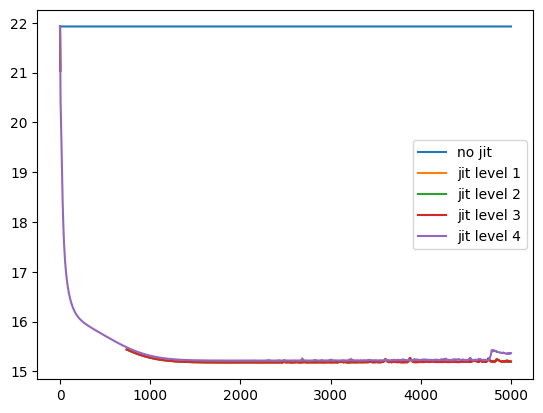

In [24]:
plt.plot(np.log(jaxELBO_no_jit), label='no jit')
plt.plot(np.log(jaxELBO1), label='jit level 1')
plt.plot(np.log(jaxELBO2), label='jit level 2')
plt.plot(np.log(jaxELBO3), label='jit level 3')
plt.plot(np.log(jaxELBO4), label='jit level 4')
plt.legend()
plt.show()

- Jitting a class is more involved in JAX than with pytorch, the best performances require some specific JAX knowledge that we exposed in each subsection of this document.
- When jitting with JAX we fall back on quite the same difficulties as when jitting with pytorch trace.
- However, JAX offers clear ways to overcome the difficulties that pytorch tracing does not offer (scan, static_argnums, pytrees, ...)
- In this particular example on **GPU**, **jitted JAX can perform twice as fast as jitted pytorch**. But in this particular example on **CPU**, JAX is slower than pytorch; is it link with the points raised in [https://jax.readthedocs.io/en/latest/faq.html#benchmarking-jax-code](https://jax.readthedocs.io/en/latest/faq.html#benchmarking-jax-code) ? However, this also recalls what we can often read online: JAX is particularly suited for GPU optimization. We need to test JAX on other examples involving neural networks, mini-batches, etc. in order to understand JAX potential on CPU optimization too.
